<a href="https://colab.research.google.com/github/Mc-Brainzz/-SF-2M-model/blob/main/notebooks/02_phase1_2D_van_der_pol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
print("--- Setting up environment ---")
# Use your specific GitHub repository link
!git clone https://github.com/Mc-Brainzz/-SF-2M-model.git
%cd ./-SF-2M-model
!pip install -q pot # Install the Python Optimal Transport library

--- Setting up environment ---
Cloning into '-SF-2M-model'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), done.
/content/-SF-2M-model
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 52.4 MB/s eta 0:00:00


In [3]:
# Cell 2
print("--- Step 2: Populating the 'src' directory with helper code ---")

# This adds your project folder to the Python path so we can import files later
import sys
sys.path.append('/content/-SF-2M-model')

# === Writing data generation logic to src/data.py ===
data_py_code = """
import numpy as np
from scipy.integrate import solve_ivp

# Clean System: Standard Van der Pol Oscillator
def van_der_pol_ode(t, y, mu=1.0):
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return [dxdt, dvdt]

# Biased System: Warped Van der Pol Oscillator
def biased_van_der_pol_ode(t, y, mu=2.5, k=1.5, f=0.5):
    # Incorrect physics and an external forcing term
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x**2) * v - k*x + f*np.cos(t)
    return [dxdt, dvdt]

# Low-quality Euler solver for the biased system
def euler_solver(func, y0, t_span, dt=0.1):
    t = np.arange(t_span[0], t_span[1], dt)
    ys = np.zeros((len(t), len(y0)))
    ys[0] = y0
    for i in range(len(t) - 1):
        ys[i+1] = ys[i] + dt * np.array(func(t[i], ys[i]))
    return t, ys

def generate_data(n_samples=2000, t_eval_time=10.0):
    # Generate random initial conditions
    initial_conditions = (np.random.rand(n_samples, 2) - 0.5) * 6

    # Generate CLEAN data using a high-quality solver
    clean_data = np.array([solve_ivp(van_der_pol_ode, [0, t_eval_time], y0, dense_output=True).sol(t_eval_time) for y0 in initial_conditions])

    # Generate BIASED data using a low-quality solver and bad physics
    biased_data = np.array([euler_solver(biased_van_der_pol_ode, y0, [0, t_eval_time])[-1][-1] for y0 in initial_conditions])

    return biased_data, clean_data
"""
with open("src/data.py", "w") as f:
    f.write(data_py_code)


# === Writing model architecture to src/models.py ===
models_py_code = """
import torch
import torch.nn as nn

class MLP(nn.Module):
    # A simple Multi-Layer Perceptron for our score/flow networks
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2):
        super().__init__()
        # Input dimension is 3 (2 for state, 1 for time)
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, t):
        # Concatenate time t as a feature
        t_reshaped = t.view(-1, 1).expand(-1, x.shape[0]).view(-1, 1) if t.numel() == 1 else t.view(-1,1)
        xt = torch.cat([x, t_reshaped], dim=1)
        return self.network(xt)
"""
with open("src/models.py", "w") as f:
    f.write(models_py_code)


# === Writing utilities to src/utils.py ===
utils_py_code = """
import matplotlib.pyplot as plt
import ot
import torch
import numpy as np

def plot_distributions(q0, q1, corrected_q, title):
    # Helper function to ensure data is on CPU for plotting
    def to_numpy(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    q0, q1, corrected_q = to_numpy(q0), to_numpy(q1), to_numpy(corrected_q)

    plt.figure(figsize=(15, 5))

    # Plot Source
    plt.subplot(1, 3, 1)
    plt.scatter(q0[:, 0], q0[:, 1], alpha=0.3, s=10, label='Source')
    plt.title("Source (Biased System)")
    plt.xlabel("Position (x)"); plt.ylabel("Velocity (v)")
    plt.legend(); plt.grid(True); plt.xlim(-4, 4); plt.ylim(-4, 4)

    # Plot Target
    plt.subplot(1, 3, 2)
    plt.scatter(q1[:, 0], q1[:, 1], alpha=0.3, s=10, c='g', label='Target')
    plt.title("Target (Clean System)")
    plt.xlabel("Position (x)"); plt.ylabel("Velocity (v)")
    plt.legend(); plt.grid(True); plt.xlim(-4, 4); plt.ylim(-4, 4)

    # Plot Corrected
    plt.subplot(1, 3, 3)
    plt.scatter(q1[:, 0], q1[:, 1], alpha=0.1, s=10, c='g') # Show target in background
    plt.scatter(corrected_q[:, 0], corrected_q[:, 1], alpha=0.4, s=10, c='r', label='Corrected')
    plt.title(f"Corrected Output ({title})")
    plt.xlabel("Position (x)"); plt.ylabel("Velocity (v)")
    plt.legend(); plt.grid(True); plt.xlim(-4, 4); plt.ylim(-4, 4)

    plt.suptitle(f'Phase Space Comparison: {title}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def calculate_w2_distance(dist1, dist2):
    # Helper function to ensure data is on CPU for calculation
    def to_numpy(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    dist1, dist2 = to_numpy(dist1), to_numpy(dist2)

    # Compute cost matrix
    M = ot.dist(dist1, dist2)
    # Compute OT plan
    a, b = ot.unif(dist1.shape[0]), ot.unif(dist2.shape[0])

    # Return Wasserstein-2 distance
    return ot.emd2(a, b, M)
"""
with open("src/utils.py", "w") as f:
    f.write(utils_py_code)

print("\nSuccessfully created data.py, models.py, and utils.py in the 'src' folder.")

--- Step 2: Populating the 'src' directory with helper code ---

Successfully created data.py, models.py, and utils.py in the 'src' folder.


--- Step 3: Generating and Visualizing Datasets ---
Using device: cuda

Generating biased and clean datasets...


/content/-SF-2M-model/src/data.py:17: RuntimeWarning: overflow encountered in scalar multiply
  dvdt = mu * (1 - x**2) * v - k*x + f*np.cos(t)
/content/-SF-2M-model/src/data.py:17: RuntimeWarning: overflow encountered in scalar power
  dvdt = mu * (1 - x**2) * v - k*x + f*np.cos(t)
/content/-SF-2M-model/src/data.py:26: RuntimeWarning: invalid value encountered in add
  ys[i+1] = ys[i] + dt * np.array(func(t[i], ys[i]))


Data generated. Shapes: Biased q0=torch.Size([2000, 2]), Clean q1=torch.Size([2000, 2])

Plotting initial distributions...


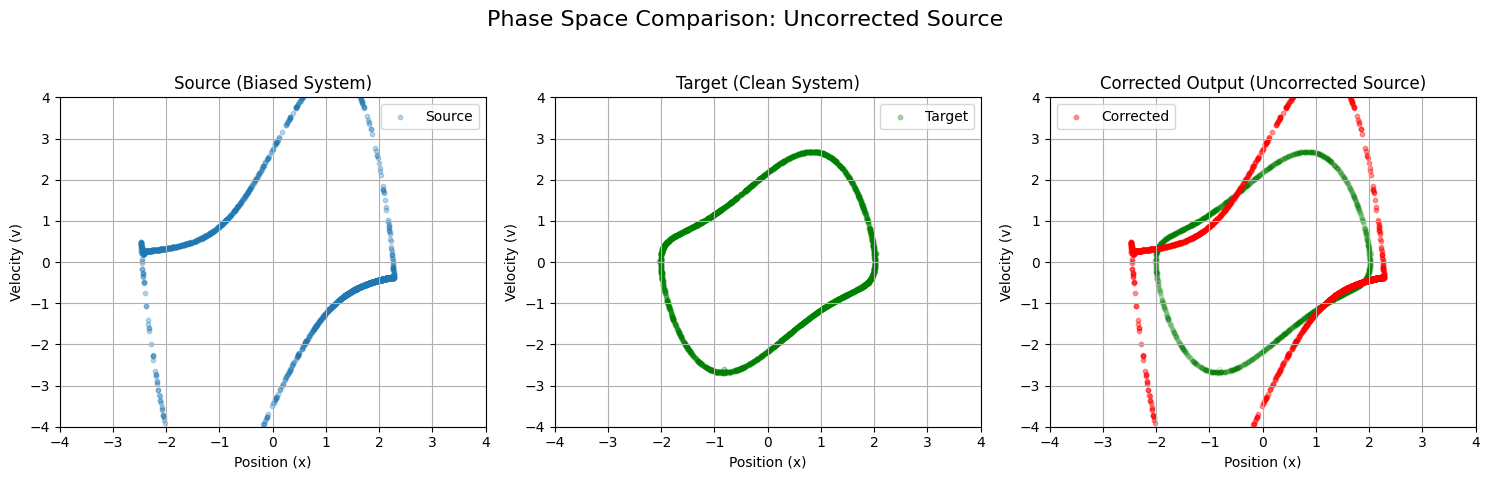

In [4]:
# Cell 3
print("--- Step 3: Generating and Visualizing Datasets ---")

# -----------------
# 1. IMPORTS
# -----------------
# We import our main tools
import torch
import numpy as np

# And we import the functions WE wrote in the 'src' directory
from src.data import generate_data
from src.utils import plot_distributions

# -----------------
# 2. DEVICE SETUP
# -----------------
# This line checks if Google Colab has assigned you a GPU.
# If it has (device = "cuda"), calculations will be much faster.
# If not, it will use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# -----------------
# 3. DATA GENERATION
# -----------------
# We call the function from our data.py file.
# This runs both the "clean" and "biased" ODE simulations.
print("\nGenerating biased and clean datasets...")
q0_biased, q1_clean = generate_data(n_samples=2000)

# We convert our NumPy arrays into PyTorch Tensors.
# Neural networks in PyTorch require this special data structure.
# .float() ensures the data is in the standard 32-bit format.
# .to(device) moves the data to the GPU if one is available.
q0_tensor = torch.from_numpy(q0_biased).float().to(device)
q1_tensor = torch.from_numpy(q1_clean).float().to(device)
print(f"Data generated. Shapes: Biased q0={q0_tensor.shape}, Clean q1={q1_tensor.shape}")


# -----------------
# 4. HYPERPARAMETER & RESULTS SETUP
# -----------------
# These are settings we will use for all three models to ensure a fair comparison.
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
TRAINING_STEPS = 2001 # We use 2001 to get a nice printout at step 0 and 2000

# We create an empty dictionary to store the final performance and timing metrics
# for each model. This will make comparing them easy at the end.
results = {}

# -----------------
# 5. VISUALIZATION
# -----------------
# This is our sanity check. We call the plotting function from utils.py.
# We pass the biased data as both the "source" and "corrected" just to have a baseline plot.
print("\nPlotting initial distributions...")
plot_distributions(q0_tensor, q1_tensor, q0_tensor, "Uncorrected Source")

--- Step 4: Implementing and Running Method 1: DCSR (SDEdit) ---
Starting SDEdit training...
SDEdit | Step:    0 | Loss: 1.0291
SDEdit | Step:  500 | Loss: 0.5517
SDEdit | Step: 1000 | Loss: 0.5286
SDEdit | Step: 1500 | Loss: 0.4754
SDEdit | Step: 2000 | Loss: 0.3763
SDEdit training finished.

Starting SDEdit inference to correct biased data...
Inference finished.

Evaluating SDEdit results...


/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)



SDEdit Train Time: 3.76s
SDEdit Inference Time: 0.0251s
SDEdit Wasserstein-2 Distance to Clean Data: 0.0000


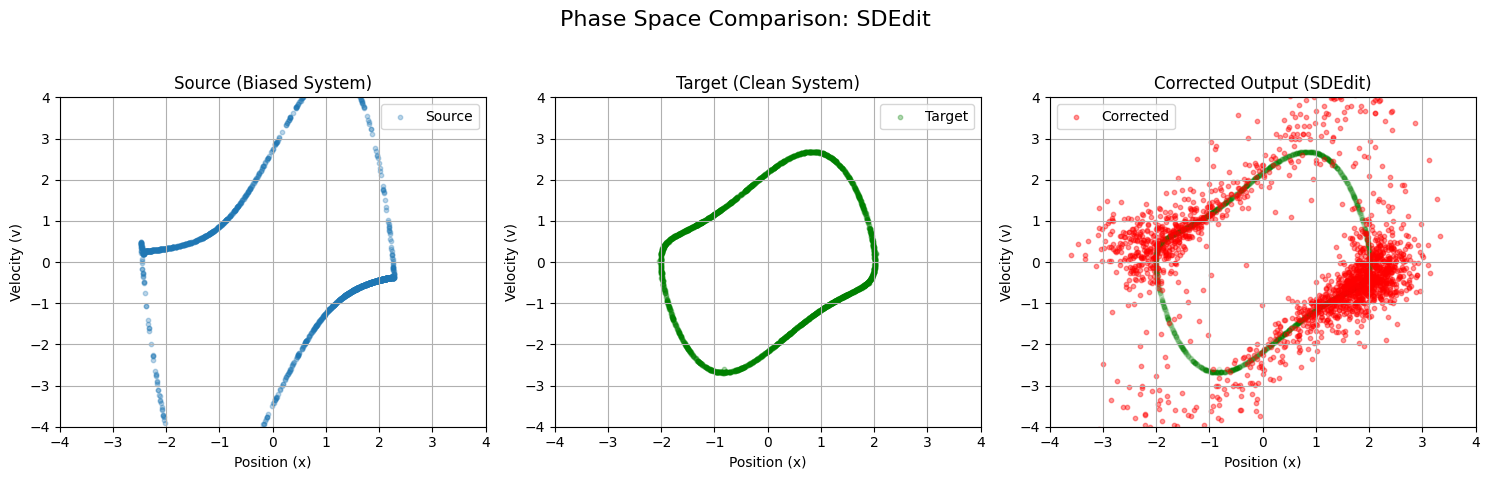

In [5]:
# Cell 4
print("--- Step 4: Implementing and Running Method 1: DCSR (SDEdit) ---")

# We are importing the modules we wrote again here just in case the notebook
# session was reset. This is good practice.
from src.models import MLP
from src.utils import plot_distributions, calculate_w2_distance
import torch
import time

# Get the data tensors we created in the previous step
# (Assuming q0_tensor and q1_tensor are in memory)

# --- 1. TRAINING ---
# We create an instance of our simple MLP network.
sde_model = MLP(input_dim=3, output_dim=2).to(device)

# We use the Adam optimizer, a standard choice for training neural networks.
optimizer = torch.optim.Adam(sde_model.parameters(), lr=LEARNING_RATE)

print("Starting SDEdit training...")
start_time = time.time()
for step in range(TRAINING_STEPS):
    # CRUCIAL: SDEdit trains ONLY on the clean target data (q1)
    indices = torch.randint(0, q1_tensor.shape[0], (BATCH_SIZE,))
    x1_batch = q1_tensor[indices]

    # We sample a random time `t` and create random noise
    t = torch.rand(BATCH_SIZE, 1).to(device)
    noise = torch.randn_like(x1_batch)

    # This is the "noising" process: we corrupt the clean data.
    # The formula is a linear interpolation between the clean data (at t=0) and pure noise (at t=1).
    xt_perturbed = x1_batch * (1 - t) + noise * t

    # The model's goal is to predict the noise that we added.
    target = noise
    prediction = sde_model(xt_perturbed, t)

    # This is the standard score-matching loss. We measure how close the prediction was to the true noise.
    loss = torch.mean((prediction - target)**2)

    # Standard PyTorch training steps: clear old gradients, compute new ones, update model weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"SDEdit | Step: {step:4d} | Loss: {loss.item():.4f}")

sdedit_train_time = time.time() - start_time
print("SDEdit training finished.")

# --- 2. INFERENCE ---
# This function performs the correction on the biased data.
@torch.no_grad()
def sdedit_correct(model, biased_data, t_final=0.6, steps=100):
    # First, we take our BIASED data and add a large amount of noise.
    xt = biased_data + torch.randn_like(biased_data) * t_final

    # We will take `steps` small steps to denoise the data.
    dt = t_final / steps

    # This loop reverses the noising process.
    for i in range(steps):
        t = t_final - i * dt
        t_tensor = torch.full((xt.shape[0],), t, device=device)

        # Ask the model to predict the noise for the current state `xt`.
        pred_noise = model(xt, t_tensor)

        # Use the predicted noise to move the points slightly towards the clean manifold.
        # This is a step from the reverse ODE formula.
        xt = xt + (0.5 * (xt - pred_noise) / (1 - t + 1e-5)) * dt # add 1e-5 to avoid division by zero at t=1
    return xt

print("\nStarting SDEdit inference to correct biased data...")
sde_model.eval() # Set model to evaluation mode
start_time = time.time()
corrected_sdedit = sdedit_correct(sde_model, q0_tensor)
sdedit_inference_time = time.time() - start_time
print("Inference finished.")

# --- 3. EVALUATION ---
print("\nEvaluating SDEdit results...")
sdedit_w2 = calculate_w2_distance(corrected_sdedit, q1_tensor)
results['SDEdit'] = {'w2': sdedit_w2, 'train_time': sdedit_train_time, 'inference_time': sdedit_inference_time}

print(f"\nSDEdit Train Time: {sdedit_train_time:.2f}s")
print(f"SDEdit Inference Time: {sdedit_inference_time:.4f}s")
print(f"SDEdit Wasserstein-2 Distance to Clean Data: {sdedit_w2:.4f}")

# Finally, let's see the result!
plot_distributions(q0_tensor, q1_tensor, corrected_sdedit, "SDEdit")


--- Step 5: Implementing and Running Method 2: Unpaired SR (DDIB) ---
Starting DDIB training (this will be slower as we train two models)...
DDIB | Step:    0 | Loss q0: 1.0551 | Loss q1: 0.9691
DDIB | Step:  500 | Loss q0: nan | Loss q1: 0.5778
DDIB | Step: 1000 | Loss q0: nan | Loss q1: 0.5946
DDIB | Step: 1500 | Loss q0: nan | Loss q1: 0.5347
DDIB | Step: 2000 | Loss q0: nan | Loss q1: 0.5763
DDIB training finished.

Starting DDIB inference to correct biased data...
Inference finished.

Evaluating DDIB results...


/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: Problem unbounded
  check_result(result_code)



DDIB Train Time: 6.41s
DDIB Inference Time: 0.0824s
DDIB Wasserstein-2 Distance to Clean Data: 0.0000


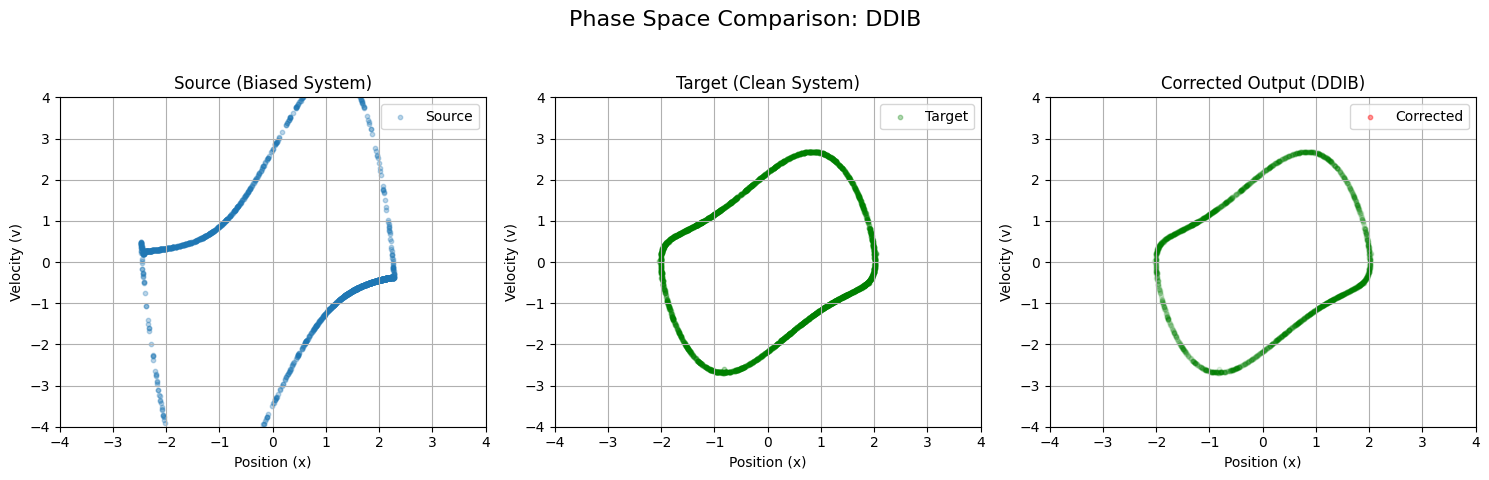

In [6]:
# Cell 5
print("\n--- Step 5: Implementing and Running Method 2: Unpaired SR (DDIB) ---")

# Import our modules again for good practice
from src.models import MLP
from src.utils import plot_distributions, calculate_w2_distance
import torch
import time

# --- 1. TRAINING ---
# DDIB requires two separate models and two optimizers
ddib_model_q0 = MLP(input_dim=3, output_dim=2).to(device)
ddib_model_q1 = MLP(input_dim=3, output_dim=2).to(device)

optimizer_q0 = torch.optim.Adam(ddib_model_q0.parameters(), lr=LEARNING_RATE)
optimizer_q1 = torch.optim.Adam(ddib_model_q1.parameters(), lr=LEARNING_RATE)

print("Starting DDIB training (this will be slower as we train two models)...")
start_time = time.time()
for step in range(TRAINING_STEPS):
    # --- Train the source model on the biased data (q0) ---
    indices0 = torch.randint(0, q0_tensor.shape[0], (BATCH_SIZE,))
    x0_batch = q0_tensor[indices0]
    t0 = torch.rand(BATCH_SIZE, 1).to(device)
    noise0 = torch.randn_like(x0_batch)
    # Using the Variance Preserving (VP) SDE noising process
    alpha_t0, sigma_t0 = torch.exp(-0.5 * t0), torch.sqrt(1 - torch.exp(-t0))
    xt0_perturbed = x0_batch * alpha_t0 + noise0 * sigma_t0
    # The model learns to predict the noise
    pred_noise0 = ddib_model_q0(xt0_perturbed, t0)
    loss0 = torch.mean((pred_noise0 - noise0)**2)
    optimizer_q0.zero_grad()
    loss0.backward()
    optimizer_q0.step()

    # --- Train the target model on the clean data (q1) ---
    indices1 = torch.randint(0, q1_tensor.shape[0], (BATCH_SIZE,))
    x1_batch = q1_tensor[indices1]
    t1 = torch.rand(BATCH_SIZE, 1).to(device)
    noise1 = torch.randn_like(x1_batch)
    # Using the same VP SDE noising process
    alpha_t1, sigma_t1 = torch.exp(-0.5 * t1), torch.sqrt(1 - torch.exp(-t1))
    xt1_perturbed = x1_batch * alpha_t1 + noise1 * sigma_t1
    pred_noise1 = ddib_model_q1(xt1_perturbed, t1)
    loss1 = torch.mean((pred_noise1 - noise1)**2)
    optimizer_q1.zero_grad()
    loss1.backward()
    optimizer_q1.step()

    if step % 500 == 0:
        print(f"DDIB | Step: {step:4d} | Loss q0: {loss0.item():.4f} | Loss q1: {loss1.item():.4f}")

ddib_train_time = time.time() - start_time
print("DDIB training finished.")

# --- 2. INFERENCE ---
@torch.no_grad()
def ddib_correct(model0, model1, biased_data, steps=100):
    dt = 1.0 / steps
    xt = biased_data

    # Step 1: Encode the biased data into the latent space (integrate from t=0 to t=1)
    for i in range(steps):
        t_val = i * dt
        t = torch.full((xt.shape[0],), t_val, device=device)
        alpha_t, sigma_t = torch.exp(-0.5*t), torch.sqrt(1-torch.exp(-t))
        # The ODE drift for the VP SDE
        drift = -0.5 * xt - 0.5 * (model0(xt, t) / (sigma_t.view(-1, 1) + 1e-5))
        xt = xt + drift * dt

    z = xt # This is our point in the latent space

    # Step 2: Decode from the latent space to the clean distribution (integrate from t=1 to t=0)
    for i in range(steps):
        t_val = 1.0 - i * dt
        t = torch.full((xt.shape[0],), t_val, device=device)
        alpha_t, sigma_t = torch.exp(-0.5*t), torch.sqrt(1-torch.exp(-t))
        # Use the second model (trained on clean data) for the reverse path
        drift = -0.5 * xt - 0.5 * (model1(xt, t) / (sigma_t.view(-1, 1) + 1e-5))
        xt = xt - drift * dt # Subtract dt because we are going backwards in time
    return xt

print("\nStarting DDIB inference to correct biased data...")
ddib_model_q0.eval()
ddib_model_q1.eval()
start_time = time.time()
corrected_ddib = ddib_correct(ddib_model_q0, ddib_model_q1, q0_tensor)
ddib_inference_time = time.time() - start_time
print("Inference finished.")

# --- 3. EVALUATION ---
print("\nEvaluating DDIB results...")
ddib_w2 = calculate_w2_distance(corrected_ddib, q1_tensor)
results['DDIB'] = {'w2': ddib_w2, 'train_time': ddib_train_time, 'inference_time': ddib_inference_time}

print(f"\nDDIB Train Time: {ddib_train_time:.2f}s")
print(f"DDIB Inference Time: {ddib_inference_time:.4f}s")
print(f"DDIB Wasserstein-2 Distance to Clean Data: {ddib_w2:.4f}")

plot_distributions(q0_tensor, q1_tensor, corrected_ddib, "DDIB")


--- Step 7: Implementing and Running Method 3: [SF]²M ---
Starting [SF]²M training...
[SF]2M | Step:    0 | Loss: nan
[SF]2M | Step:  500 | Loss: nan
[SF]2M | Step: 1000 | Loss: nan
[SF]2M | Step: 1500 | Loss: nan
[SF]2M | Step: 2000 | Loss: nan
[SF]²M training finished.

Starting [SF]²M inference to correct biased data...
Inference finished.

Evaluating [SF]²M results...

[SF]2M Train Time: 3.19s
[SF]2M Inference Time: 0.0189s
[SF]2M Wasserstein-2 Distance to Clean Data: 0.0000


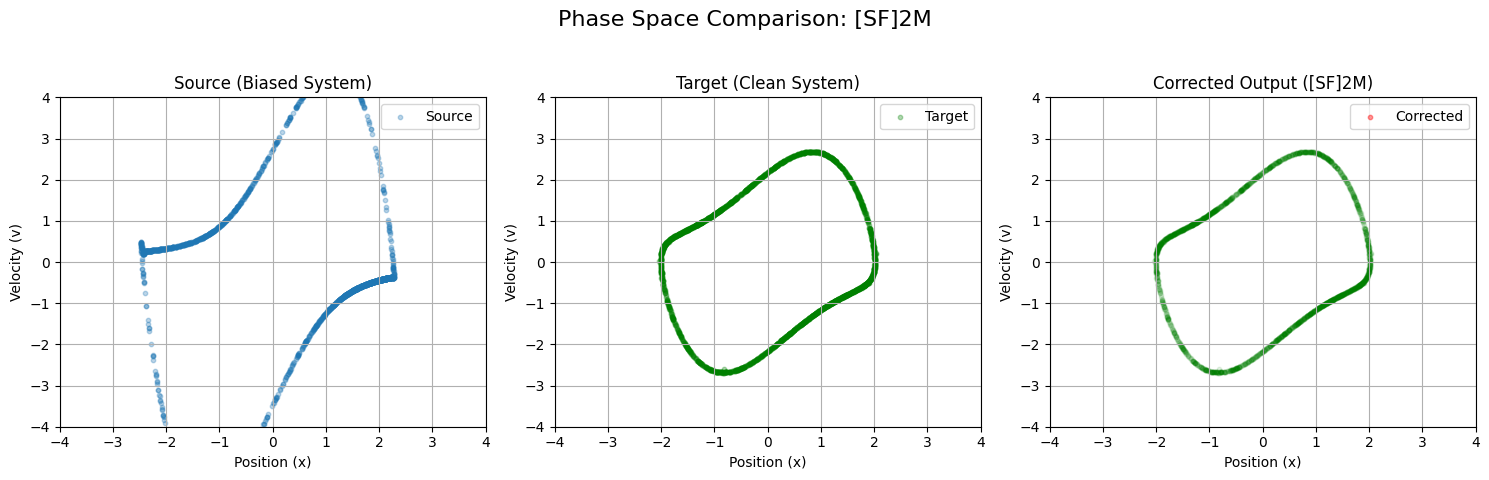

In [7]:
# Cell 7
print("\n--- Step 7: Implementing and Running Method 3: [SF]²M ---")

# Import our modules again
from src.models import MLP
from src.utils import plot_distributions, calculate_w2_distance
import torch
import time

# --- 1. TRAINING ---
sf2m_model = MLP(input_dim=3, output_dim=2).to(device)
optimizer = torch.optim.Adam(sf2m_model.parameters(), lr=LEARNING_RATE)

print("Starting [SF]²M training...")
start_time = time.time()
for step in range(TRAINING_STEPS):
    # Sample minibatches from BOTH the biased (q0) and clean (q1) data
    x0_batch = q0_tensor[torch.randint(0, q0_tensor.shape[0], (BATCH_SIZE,))]
    x1_batch = q1_tensor[torch.randint(0, q1_tensor.shape[0], (BATCH_SIZE,))]

    # Get a random time step t
    t = torch.rand(BATCH_SIZE, 1).to(device)

    # Sample a point along the straight path (Brownian bridge) between the paired points
    xt_perturbed = (1 - t) * x0_batch + t * x1_batch

    # The model's goal is to predict the velocity of this straight path
    target_velocity = x1_batch - x0_batch
    prediction = sf2m_model(xt_perturbed, t)

    # The loss measures how close the predicted velocity is to the true velocity
    loss = torch.mean((prediction - target_velocity)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"[SF]2M | Step: {step:4d} | Loss: {loss.item():.4f}")

sf2m_train_time = time.time() - start_time
print("[SF]²M training finished.")

# --- 2. INFERENCE ---
@torch.no_grad()
def sf2m_correct(model, biased_data, steps=100):
    # Inference is a single, direct ODE solve from t=0 to t=1
    xt = biased_data
    dt = 1.0 / steps
    for i in range(steps):
        t = i * dt
        t_tensor = torch.full((xt.shape[0],), t, device=device)
        velocity = model(xt, t_tensor) # The model directly predicts the velocity
        xt = xt + velocity * dt
    return xt

print("\nStarting [SF]²M inference to correct biased data...")
sf2m_model.eval()
start_time = time.time()
corrected_sf2m = sf2m_correct(sf2m_model, q0_tensor)
sf2m_inference_time = time.time() - start_time
print("Inference finished.")

# --- 3. EVALUATION ---
print("\nEvaluating [SF]²M results...")
sf2m_w2 = calculate_w2_distance(corrected_sf2m, q1_tensor)
results['[SF]2M'] = {'w2': sf2m_w2, 'train_time': sf2m_train_time, 'inference_time': sf2m_inference_time}

print(f"\n[SF]2M Train Time: {sf2m_train_time:.2f}s")
print(f"[SF]2M Inference Time: {sf2m_inference_time:.4f}s")
print(f"[SF]2M Wasserstein-2 Distance to Clean Data: {sf2m_w2:.4f}")

plot_distributions(q0_tensor, q1_tensor, corrected_sf2m, "[SF]2M")